In [16]:

import csv
with open("/home/qiu/study_college/machine_learning/language/machine-learningntut-2021-autumn-asr/ML@NTUT-2021-Autumn-ASR/train-toneless_update.csv") as csvfile:
    rows = csv.reader(csvfile)
    for row in rows:
        a = row[0]
        b = row[1]
        f = open("/home/qiu/study_college/machine_learning/language/machine-learningntut-2021-autumn-asr/ML@NTUT-2021-Autumn-ASR/train/txt/"+a+'.txt','w')
        f.write(b)
        f.close()


In [1]:
# -*- coding: utf-8 -*-

from keras.models import Model
from keras.layers import Input, Activation, Conv1D, Lambda, Add, Multiply, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
from keras import backend as K
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
import random
import pickle
import glob
from tqdm import tqdm
import os

from python_speech_features import mfcc
import scipy.io.wavfile as wav
import librosa
from IPython.display import Audio


2022-01-18 05:30:24.590075: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-18 05:30:24.590095: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def get_wav_files(wav_path):
    wav_files = []
    for (dirpath, dirnames, filenames) in os.walk(wav_path):
        for filename in filenames:
            if filename.endswith(".wav") or filename.endswith(".WAV"):
                filename_path = os.path.join(dirpath, filename)
                wav_files.append(filename_path)
    return wav_files    

def get_tran_texts(wav_files, tran_path):
    tran_texts = []
    for wav_file in wav_files:
        basename = os.path.basename(wav_file)
        x = os.path.splitext(basename)[0]
        tran_file = os.path.join(tran_path,x+ '.txt') 
        if os.path.exists(tran_file) is False:
            return None
        fd = open(tran_file, 'r')
        text = fd.readline()
        tran_texts.append(text.split('\n')[0])
        fd.close()
    return tran_texts  

In [3]:
tran_path = "/home/qiu/study_college/machine_learning/language/machine-learningntut-2021-autumn-asr/ML@NTUT-2021-Autumn-ASR/train/txt"
wav_files=get_wav_files('/home/qiu/study_college/machine_learning/language/machine-learningntut-2021-autumn-asr/ML@NTUT-2021-Autumn-ASR/')
text_paths = glob.glob("/home/qiu/study_college/machine_learning/language/machine-learningntut-2021-autumn-asr/ML@NTUT-2021-Autumn-ASR/train/txt/*.txt")

total = len(text_paths)
print(total)

with open(text_paths[0], 'r', encoding='utf8') as fr:
    lines = fr.readlines()
    print(lines)






3120
['tsu lang tsit e ka sing ti su kak hue a tui tsia e ku tshu pinn tsiann khuann bo tsiunn bak']


In [4]:
texts = []
paths = []
for path in text_paths:
    with open(path, 'r', encoding='utf8') as fr:
        lines = fr.readlines()
        line = lines[0].strip('\n').replace(' ', '')
        texts.append(line)
        paths.append(path.rstrip('.txt'))

print(paths[0])
print(texts[0])

/home/qiu/study_college/machine_learning/language/machine-learningntut-2021-autumn-asr/ML@NTUT-2021-Autumn-ASR/train/txt/607
tsulangtsitekasingtisukakhueatuitsiaekutshupinntsiannkhuannbotsiunnbak


In [5]:
mfcc_dim =13

def load_and_trim(path):
    audio, sr =librosa.load(path)
    energy = librosa.feature.rms(audio)
    frames = np.nonzero(energy >= np.max(energy) /5)
    indices = librosa.core.frames_to_samples(frames)[1]
    audio = audio[indices[0]:indices[-1]] if indices.size else audio[0:0]
    return audio,sr



In [6]:
features = []
for i in tqdm(range(len(wav_files))):
              path = wav_files[i]
              audio, sr = load_and_trim(path)
              features.append(mfcc(audio, sr, numcep = mfcc_dim, nfft = 551))        

100%|███████████████████████████████████████| 3465/3465 [00:36<00:00, 93.76it/s]


In [7]:
import random
print(len(features), features[0].shape)

samples = random.sample(features, 100)
samples = np.vstack(samples)

mfcc_mean = np.mean(samples, axis=0)
mfcc_std = np.std(samples, axis=0)
print(mfcc_mean)
print(mfcc_std)

features = [(feature - mfcc_mean) / (mfcc_std + 1e-14) for feature in features]



3465 (268, 13)
[ -5.99367404  -4.70104057  -4.61942964  -0.55295771  -2.69897968
 -13.95263008   3.90004593 -10.39611293  -6.81300948  -6.06156385
 -12.73426962 -10.37628469  -6.82708139]
[ 3.78717529 16.19135454 19.25296034 19.22915484 16.13392409 17.92319379
 14.52328862 15.17966811 14.80145203 13.52810032 13.73646184 12.1131891
 12.16730728]


In [8]:
texts= get_tran_texts(wav_files, tran_path)
chars = {}

for text in texts:
    for c in text:
        chars[c] = chars.get(c, 0) + 1

chars = sorted(chars.items(), key=lambda x: x[1], reverse=True)
chars = [char[0] for char in chars]
print(len(chars), chars[:100])

char2id = {c: i for i, c in enumerate(chars)}
id2char = {i: c for i, c in enumerate(chars)}



53 [' ', 'i', 'a', 'n', 't', 'h', 's', 'u', 'o', 'k', 'g', 'e', 'l', 'p', 'b', 'm', 'j', 'r', 'B', 'S', 'C', 'd', 'P', 'c', 'I', 'R', 'y', 'f', 'A', 'N', 'D', 'T', 'O', 'F', 'V', 'G', 'w', 'M', 'v', 'W', 'x', 'U', 'E', 'J', 'H', 'Y', 'z', 'q', 'L', 'Z', 'X', 'K', 'Q']


In [9]:
data_index = np.arange(total)
np.random.shuffle(data_index)
train_size = int(0.9 * total)
test_size = total - train_size
train_index = data_index[:train_size]
test_index = data_index[train_size:]

X_train = [features[i] for i in train_index]
Y_train = [texts[i] for i in train_index]
X_test = [features[i] for i in test_index]
Y_test = [texts[i] for i in test_index]

batch_size = 16
    
def batch_generator(x, y, batch_size=batch_size):  
    offset = 0
    while True:
        offset += batch_size
        
        if offset == batch_size or offset >= len(x):
            data_index = np.arange(len(x))
            np.random.shuffle(data_index)
            x = [x[i] for i in data_index]
            y = [y[i] for i in data_index]
            offset = batch_size
            
        X_data = x[offset - batch_size: offset]
        Y_data = y[offset - batch_size: offset]
        
        X_maxlen = max([X_data[i].shape[0] for i in range(batch_size)])
        Y_maxlen = max([len(Y_data[i]) for i in range(batch_size)])
        
        X_batch = np.zeros([batch_size, X_maxlen, mfcc_dim])
        Y_batch = np.ones([batch_size, Y_maxlen]) * len(char2id)
        X_length = np.zeros([batch_size, 1], dtype='int32')
        Y_length = np.zeros([batch_size, 1], dtype='int32')
        
        for i in range(batch_size):
            X_length[i, 0] = X_data[i].shape[0]
            X_batch[i, :X_length[i, 0], :] = X_data[i]
            
            Y_length[i, 0] = len(Y_data[i])
            Y_batch[i, :Y_length[i, 0]] = [char2id[c] for c in Y_data[i]]
        
        inputs = {'X': X_batch, 'Y': Y_batch, 'X_length': X_length, 'Y_length': Y_length}
        outputs = {'ctc': np.zeros([batch_size])}
        
        yield (inputs, outputs)


In [18]:
epochs = 40
num_blocks = 3
filters = 128

X = Input(shape=(None, mfcc_dim,), dtype='float32', name='X')
Y = Input(shape=(None,), dtype='float32', name='Y')
X_length = Input(shape=(1,), dtype='int32', name='X_length')
Y_length = Input(shape=(1,), dtype='int32', name='Y_length')

def conv1d(inputs, filters, kernel_size, dilation_rate):
    return Conv1D(filters=filters, kernel_size=kernel_size, strides=1, padding='causal', activation=None, dilation_rate=dilation_rate)(inputs)

def batchnorm(inputs):
    return BatchNormalization()(inputs)

def activation(inputs, activation):
    return Activation(activation)(inputs)

def res_block(inputs, filters, kernel_size, dilation_rate):
    hf = activation(batchnorm(conv1d(inputs, filters, kernel_size, dilation_rate)), 'tanh')
    hg = activation(batchnorm(conv1d(inputs, filters, kernel_size, dilation_rate)), 'sigmoid')
    h0 = Multiply()([hf, hg])
    
    ha = activation(batchnorm(conv1d(h0, filters, 1, 1)), 'tanh')
    hs = activation(batchnorm(conv1d(h0, filters, 1, 1)), 'tanh')
    return Add()([ha, inputs]), hs

h0 = activation(batchnorm(conv1d(X, filters, 1, 1)), 'tanh')
shortcut = []
for i in range(num_blocks):
    for r in [1, 2, 4, 8, 16]:
        h0, s = res_block(h0, filters, 7, r)
        shortcut.append(s)

h1 = activation(Add()(shortcut), 'relu')
h1 = activation(batchnorm(conv1d(h1, filters, 1, 1)), 'relu')
Y_pred = activation(batchnorm(conv1d(h1, len(char2id) + 1, 1, 1)), 'softmax')
sub_model = Model(inputs=X, outputs=Y_pred)

def calc_ctc_loss(args):
    y, yp, ypl, yl = args
    return K.ctc_batch_cost(y, yp, ypl, yl)

ctc_loss = Lambda(calc_ctc_loss, output_shape=(1,), name='ctc')([Y, Y_pred, X_length, Y_length])
model = Model(inputs=[X, Y, X_length, Y_length], outputs=ctc_loss)
optimizer = SGD(lr=0.02, momentum=0.9, nesterov=True, clipnorm=5)
model.compile(loss={'ctc': lambda ctc_true, ctc_pred: ctc_pred}, optimizer=optimizer)

checkpointer = ModelCheckpoint(filepath='allen40.h5', verbose=0)
lr_decay = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=1, min_lr=0.000)

history = model.fit_generator(
    generator=batch_generator(X_train, Y_train), 
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs, 
    validation_data=batch_generator(X_test, Y_test), 
    validation_steps=len(X_test) // batch_size, 
    callbacks=[checkpointer, lr_decay])
sub_model.save('allen40.h5')


/tmp/ipykernel_4919/3017821005.py:52: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/40
175/175 [==============================] - 581s 3s/step - loss: 113.8458 - val_loss: 110.0628 - lr: 0.0200
Epoch 2/40
175/175 [==============================] - 544s 3s/step - loss: 42.9775 - val_loss: 98.7270 - lr: 0.0200
Epoch 3/40
175/175 [==============================] - 522s 3s/step - loss: 35.0064 - val_loss: 62.9758 - lr: 0.0200
Epoch 4/40
175/175 [==============================] - 525s 3s/step - loss: 30.7669 - val_loss: 68.8978 - lr: 0.0200
Epoch 5/40
175/175 [==============================] - 533s 3s/step - loss: 27.5321 - val_loss: 70.3125 - lr: 0.0200
Epoch 6/40
175/175 [==============================] - 537s 3s/step - loss: 24.4659 - val_loss: 47.1774 - lr: 0.0200
Epoch 7/40
175/175 [==============================] - 526s 3s/step - loss: 21.5801 - val_loss: 75.4689 - lr: 0.0200
Epoch 8/40
175/175 [==============================] - 513s 3s/step - loss: 19.6672 - val_loss: 40.2590 - lr: 0.0200
Epoch 9/40
175/175 [==============================] - 510s 3s/step - l

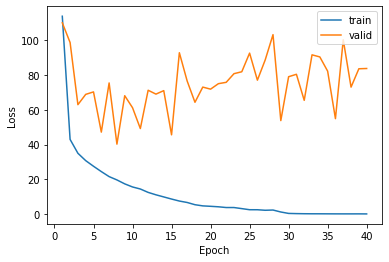

In [19]:
with open('dictionary.pkl', 'wb') as fw:
    pickle.dump([char2id, id2char, mfcc_mean, mfcc_std], fw)
    
train_loss = history.history['loss']
valid_loss = history.history['val_loss']
plt.plot(np.linspace(1, epochs, epochs), train_loss, label='train')
plt.plot(np.linspace(1, epochs, epochs), valid_loss, label='valid')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

  

In [21]:
# -*- coding: utf-8 -*-

from keras.models import load_model
from keras import backend as K
import numpy as np
import librosa
from python_speech_features import mfcc
import pickle
import glob

wavs = glob.glob('/home/qiu/study_college/machine_learning/language/machine-learningntut-2021-autumn-asr/ML@NTUT-2021-Autumn-ASR/test-shuf/*.wav')
with open('dictionary.pkl', 'rb') as fr:
    [char2id, id2char, mfcc_mean, mfcc_std] = pickle.load(fr)

mfcc_dim = 13
model = load_model('allen40.h5', compile=False)

with open('predict41.csv','w') as f:
    f.write('id,text\n')
    for j in range(1,347):
        path1=['/home/qiu/study_college/machine_learning/language/machine-learningntut-2021-autumn-asr/ML@NTUT-2021-Autumn-ASR/test-shuf/',str(j),'.wav']
        path=''.join(path1)
        #print(path)
        audio, sr=load_and_trim(path)
        X_data = mfcc(audio, sr, numcep=mfcc_dim, nfft=551)
        X_data = (X_data - mfcc_mean) / (mfcc_std + 1e-14)
        #print(X_data.shape)

        pred = model.predict(np.expand_dims(X_data, axis=0))
        pred_ids = K.eval(K.ctc_decode(pred, [X_data.shape[0]], greedy=False, beam_width=10, top_paths=1)[0][0])
        pred_ids = pred_ids.flatten().tolist()
        while -1 in pred_ids:
            pred_ids.remove(-1)
        #print(''.join([id2char[i] for i in pred_ids]))
        f.write(str(j) +  ',' + (''.join([id2char[i] for i in pred_ids])) + '\n')